<a href="https://colab.research.google.com/github/a2kiti/ConvTranspose2d_for_ONNX/blob/master/ConvTranpose2D_for_onnxjs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make pytorch model (example DCGAN)

In [0]:
import os
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import cv2

In [0]:
class Generator(nn.Module):
    def __init__(self, nz=100, nch_g=64, nch=1):
        super(Generator, self).__init__()

        # (100, 1, 1) -> (256, 4, 4)
        self.conv0 = nn.ConvTranspose2d(nz, nch_g * 4, 4, 1, 0)
        self.bn0 = nn.BatchNorm2d(nch_g * 4)
        self.act0 = nn.ReLU()
        
        # (256, 4, 4) -> (128, 8, 8)
        self.conv1 = nn.ConvTranspose2d(nch_g*4, nch_g * 2, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(nch_g * 2)
        self.act1 = nn.ReLU()
        
        # (128, 8, 8) -> (64, 16, 16)
        self.conv2 = nn.ConvTranspose2d(nch_g*2, nch_g * 1, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(nch_g * 1)
        self.act2 = nn.ReLU()
        
        # (64, 16, 16) -> (1, 32, 32)
        self.conv3 = nn.ConvTranspose2d(nch_g*1, nch, 4, 2, 1)
        self.act3 = nn.Tanh()
        
    def forward(self, z):
        z = self.conv0(z)
        z = self.bn0(z)
        z = self.act0(z)

        z = self.conv1(z)
        z = self.bn1(z)
        z = self.act1(z)

        z = self.conv2(z)
        z = self.bn2(z)
        z = self.act2(z)

        z = self.conv3(z)
        z = self.act3(z)
        return z

class Discriminator(nn.Module):
    def __init__(self, nch=1, nch_d=64, nz=100):
        super(Discriminator, self).__init__()
        
        # (1, 32, 32) -> (64, 16, 16)
        self.conv0 = nn.Conv2d(nch, nch_d, 4, 2, 1)
        self.act0 = nn.LeakyReLU(negative_slope=0.2)
        
        # (64, 16, 16) -> (128, 8, 8)
        self.conv1 = nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(nch_g * 2)
        self.act1 = nn.LeakyReLU(negative_slope=0.2)
        
        # (128, 8, 8) -> (256, 4, 4)
        self.conv2 = nn.Conv2d(nch_d * 2, nch_d * 4, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(nch_g * 4)
        self.act2 = nn.LeakyReLU(negative_slope=0.2)
        
        # (256, 4, 4) -> (1, 1, 1)
        self.conv3 = nn.Conv2d(nch_d * 4, 1, 4, 1, 0)
         
    def forward(self, x):
        x = self.conv0(x)
        x = self.act0(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        return x.squeeze()     

In [0]:
nz = 100
nch_g = 32
nch_d = 32
lr = 0.0002
n_epoch = 10
batch_size = 100

In [4]:
# make 32*32 mnist dataset
mnist_data = datasets.MNIST('data', train=True, download=True)
x_data_mnist = mnist_data.data.numpy()
y_data_mnist = mnist_data.targets.numpy()
x_data = np.zeros((len(x_data_mnist), 32, 32), np.uint8)
for i in range(len(x_data_mnist)):
    x_data[i] = cv2.resize(x_data_mnist[i], (32,32))
x_data_mnist = x_data

class mydatasets(torch.utils.data.Dataset):
    def __init__(self, dataset, labelset, train = True):
        self.train = train
        self.labelset = labelset
        self.dataset = dataset
        self.datanum = len(dataset)
        self.labelnum = len(np.unique(labelset))

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_label = self.labelset[idx]
        out_data = self.dataset[idx]
        out_data = (out_data/255.0 - 0.5) / 0.5
        out_data = torch.from_numpy(out_data.astype(np.float32)).unsqueeze(0)
        return out_data, out_label

dataloader = torch.utils.data.DataLoader(
    mydatasets(x_data, y_data_mnist),
    batch_size=batch_size, shuffle=True)

label_num = dataloader.dataset.labelnum

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

netG = Generator(nz=nz, nch_g=nch_g).to(device) 
netD = Discriminator(nch=1, nch_d=nch_d).to(device)

criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)

fixed_noise = torch.randn(100, nz, 1, 1, device=device)

# traning loop
for epoch in range(n_epoch):
    netG.train()
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)
        real_label = data[1].to(device)

        sample_size = real_image.size(0)
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
    
        real_target = torch.full((sample_size,), 1., device=device)  
        fake_target = torch.full((sample_size,), 0., device=device)  

        #train discriminator
        netD.zero_grad()  

        output = netD(real_image)  
        loss_D_real = criterion(output, real_target) 
        
        fake_image = netG(noise) 
        
        output = netD(fake_image.detach())  
        loss_D_fake = criterion(output, fake_target)  
        
        loss_D = loss_D_real + loss_D_fake  
        loss_D.backward()  
        optimizerD.step()  

        #train generator
        netG.zero_grad()  
    
        output = netD(fake_image)  
        loss_G = criterion(output, real_target)  
        loss_G.backward()  
        
        optimizerG.step()  

        if itr % 100 == 0:
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f}'.format(epoch + 1, n_epoch,
                            itr + 1, len(dataloader), loss_D.item(), loss_G.item()))
                
    # save fake image
    netG.eval()
    fake_image = netG(fixed_noise)
    fileName = 'fake_samples_epoch_{:03d}.png'.format(epoch + 1)
    vutils.save_image(fake_image.detach(), fileName, normalize=True, nrow=10)

    # save model

torch.save(netG.state_dict(), 'netG.pth')
torch.save(netD.state_dict(), 'netD.pth')




device: cuda
[1/10][1/600] Loss_D: 0.929 Loss_G: 0.557
[1/10][101/600] Loss_D: 0.143 Loss_G: 1.323
[1/10][201/600] Loss_D: 0.040 Loss_G: 1.065
[1/10][301/600] Loss_D: 0.088 Loss_G: 0.854
[1/10][401/600] Loss_D: 0.260 Loss_G: 0.410
[1/10][501/600] Loss_D: 0.123 Loss_G: 0.665
[2/10][1/600] Loss_D: 0.158 Loss_G: 1.319
[2/10][101/600] Loss_D: 0.110 Loss_G: 0.536
[2/10][201/600] Loss_D: 0.086 Loss_G: 0.860
[2/10][301/600] Loss_D: 0.149 Loss_G: 0.812
[2/10][401/600] Loss_D: 0.099 Loss_G: 0.586
[2/10][501/600] Loss_D: 0.256 Loss_G: 0.463
[3/10][1/600] Loss_D: 0.105 Loss_G: 0.557
[3/10][101/600] Loss_D: 0.119 Loss_G: 0.518
[3/10][201/600] Loss_D: 0.253 Loss_G: 0.333
[3/10][301/600] Loss_D: 0.118 Loss_G: 0.778
[3/10][401/600] Loss_D: 0.100 Loss_G: 1.343
[3/10][501/600] Loss_D: 1.097 Loss_G: 0.842
[4/10][1/600] Loss_D: 0.085 Loss_G: 0.952
[4/10][101/600] Loss_D: 0.197 Loss_G: 0.361
[4/10][201/600] Loss_D: 0.096 Loss_G: 0.606
[4/10][301/600] Loss_D: 0.080 Loss_G: 0.779
[4/10][401/600] Loss_D: 0

# Convert generator to ONNX.js model

In [0]:
# custom ConvTranspose2D layer for onnx.js
# onnx.js can't use nn.ConvTranspose2D.
# this custom layer is conposed by torch.cat and nn.Conv2d.
# this layer has some limitations.
# Since shape method is disable, batchsize height and width must be determined.
class ConvTranspose2D_ONNXJS(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, height, width, batch_size):
        super(ConvTranspose2D_ONNXJS, self).__init__(in_channels, out_channels, kernel_size, 1, 0)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride_t = stride
        if not (self.stride_t==1 or self.stride_t==2):
            raise Exception("available stride is only 1 or 2.")

        self.padding_t = padding
        self.h = height
        self.w = width
        self.b = batch_size
        self.outpad = self.kernel_size - 1 - self.padding_t
        if self.outpad < (self.stride_t-1):
            raise Exception("outside padding is too little.")
        

    def forward(self, x):
        if self.stride_t == 2:
            #2 stride by concat
            tmp  = x.view(-1,1)
            tmp  = torch.cat([tmp, torch.zeros((self.b * self.in_channels * self.h * self.w, 1))],1)
            tmp = tmp.view(-1, self.w * 2)
            x = torch.cat([tmp,torch.zeros((self.b * self.in_channels * self.h, self.w * 2))], 1).view(-1, self.in_channels, self.h * 2, self.w * 2)
            # outside padding by concat
            hs, ws, he, we = self.outpad, self.outpad, self.outpad, self.outpad
            x = torch.cat([torch.zeros((self.b, self.in_channels, hs, self.w * 2)), x, torch.zeros((self.b, self.in_channels, he-1, self.w * 2))], 2)
            x = torch.cat([torch.zeros((self.b, self.in_channels, self.h * 2+hs+he-1, ws)), x, torch.zeros((self.b, self.in_channels, self.h*2+hs+he-1, we-1))], 3)
        else:
            # outside padding by concat
            hs, ws, he, we = self.outpad, self.outpad, self.outpad, self.outpad
            x = torch.cat([torch.zeros((self.b, self.in_channels, hs, self.w)), x, torch.zeros((self.b, self.in_channels, he, self.w))], 2)
            x = torch.cat([torch.zeros((self.b, self.in_channels, self.h+hs+he, ws)), x, torch.zeros((self.b, self.in_channels, self.h+hs+he, we))], 3)

        x = super().forward(x)
        return x

# ConvTranspose2D weight to Conv2D weight
def convert_weight(nn_weight):
    w = nn_weight[:]
    I, O, H, W = w.shape
    w = w.permute(1,0,2,3)
    w = w[:, :, torch.arange(H-1,-1,-1), :]
    w = w[:, :, :, torch.arange(W-1,-1,-1)]
    return w

In [0]:
class Generator_replace(nn.Module):
    def __init__(self, nz=100, nch_g=64, nch=1, ):
        super(Generator_replace, self).__init__()

        # (100, 1, 1) -> (256, 4, 4)
        self.conv0 = ConvTranspose2D_ONNXJS(nz, nch_g * 4, 4, 1, 0, 1, 1, 1)
        self.bn0 = nn.BatchNorm2d(nch_g * 4)
        self.act0 = nn.ReLU()
        
        # (256, 4, 4) -> (128, 8, 8)
        self.conv1 = ConvTranspose2D_ONNXJS(nch_g*4, nch_g * 2, 4, 2, 1, 4, 4, 1)
        self.bn1 = nn.BatchNorm2d(nch_g * 2)
        self.act1 = nn.ReLU()
        
        # (128, 8, 8) -> (64, 16, 16)
        self.conv2 = ConvTranspose2D_ONNXJS(nch_g*2, nch_g * 1, 4, 2, 1, 8, 8, 1)
        self.bn2 = nn.BatchNorm2d(nch_g * 1)
        self.act2 = nn.ReLU()
        
        # (64, 16, 16) -> (1, 32, 32)
        self.conv3 = ConvTranspose2D_ONNXJS(nch_g*1, nch, 4, 2, 1, 16, 16, 1)
        self.act3 = nn.Tanh()
        
    def forward(self, z):
        z = self.conv0(z)
        z = self.bn0(z)
        z = self.act0(z)

        z = self.conv1(z)
        z = self.bn1(z)
        z = self.act1(z)

        z = self.conv2(z)
        z = self.bn2(z)
        z = self.act2(z)

        z = self.conv3(z)
        z = self.act3(z)
        return z

##  copy weights

In [8]:
netG_r = Generator_replace(nz=nz, nch_g=nch_g)
netG_r.eval()
for (k, v), (k_r, v_r) in zip(netG.state_dict().items(), netG_r.state_dict().items()):
    print(k, "->", k_r)
    if len(v.shape)==0:
        v_r = v
    else:
        if len(v.shape)==4:
            v_r[:] = convert_weight(v) # ConvTranspose2D weight to Conv2D weight
        else:
            v_r[:] = v

conv0.weight -> conv0.weight
conv0.bias -> conv0.bias
bn0.weight -> bn0.weight
bn0.bias -> bn0.bias
bn0.running_mean -> bn0.running_mean
bn0.running_var -> bn0.running_var
bn0.num_batches_tracked -> bn0.num_batches_tracked
conv1.weight -> conv1.weight
conv1.bias -> conv1.bias
bn1.weight -> bn1.weight
bn1.bias -> bn1.bias
bn1.running_mean -> bn1.running_mean
bn1.running_var -> bn1.running_var
bn1.num_batches_tracked -> bn1.num_batches_tracked
conv2.weight -> conv2.weight
conv2.bias -> conv2.bias
bn2.weight -> bn2.weight
bn2.bias -> bn2.bias
bn2.running_mean -> bn2.running_mean
bn2.running_var -> bn2.running_var
bn2.num_batches_tracked -> bn2.num_batches_tracked
conv3.weight -> conv3.weight
conv3.bias -> conv3.bias


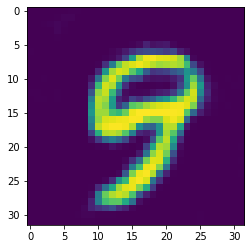

In [9]:
z = torch.randn(1, nz, 1, 1)
netG = netG.cpu()
netG.eval()
fake_image = netG(z)
im = fake_image[0,0].data.numpy()
plt.imshow(im)

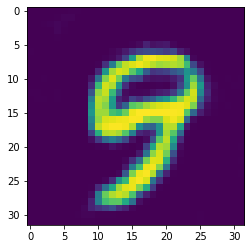

In [10]:
fake_image_r = netG_r(z)
im = fake_image_r[0,0].data.numpy()
plt.imshow(im)

In [11]:
fake_image - fake_image_r

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -5.9605e-08,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.9605e-08,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]], grad_fn=<SubBackward0>)

# export onnx file

In [0]:

torch.onnx.export(netG_r, z, 'netG.onnx')


In [13]:
!pip install onnxruntime

     |████████████████████████████████| 3.7MB 3.4MB/s 
     |████████████████████████████████| 4.8MB 28.1MB/s 


In [14]:
import onnxruntime
session = onnxruntime.InferenceSession("netG.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

ort_outs = session.run([output_name], {input_name: to_numpy(z)})

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(fake_image_r), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
